In [175]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets
from torchvision import transforms

# Creamos una capa de convolución

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super(ConvLayer, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.conv(x))
    
# Max Pooling + Batch Normalization + Dropout (opcional)
class MaxPoolBN(torch.nn.Module): 
    def __init__(self, in_channels, kernel_size = 2, stride=2, padding=0, dropout=0.1):
        super(MaxPoolBN, self).__init__()
        self.max_pool = torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.bn(self.max_pool(x)))
    
# Capa densa + dropout (opcional)
class Dense(torch.nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(Dense, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.linear(x))
    
# structure = [N, L1, k1, ..., Ln, kn], con L la cantidad de capas y k el kernel size
class ConvNet(torch.nn.Module):
    def __init__(self,in_channels, structure, size, classes):
        super(ConvNet, self).__init__()
        self.size = size
        self.structure = structure
        self.L = [structure[i] for i in range(len(structure)) if i % 2 == 1]
        self.k = [structure[i] for i in range(len(structure)) if i % 2 == 0 and i != 0]
        self.layers = torch.nn.ModuleList()
        for i in range(len(self.L)):
            if i == 0:
                self.layers.append(ConvLayer(in_channels, self.L[i], self.k[i]))
                self.layers.append(torch.nn.Dropout(0.1))
            else:
                self.layers.append(ConvLayer(self.L[i-1], self.L[i], self.k[i]))
                self.layers.append(torch.nn.Dropout(0.1))
                
            # Max pooling en cantidad par de capas 
            if i % 2 == 1:
                self.layers.append(MaxPoolBN(self.L[i], 2))
                self.size = self.size // 2
                
        # Caso impares
        if len(self.L) % 2 == 1:
            self.layers.append(MaxPoolBN(self.L[-1], 2))
            self.size = self.size // 2
            
        # Cabeza clasificadora
        self.layers.append(torch.nn.Flatten())
        self.layers.append(Dense(self.L[-1] * self.size * self.size, 128))
        self.layers.append(torch.nn.Dropout(0.5))
        self.layers.append(Dense(128, classes))
        if self.size == 0:
            self.size=1       
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def get_transforms(std=0.5, mean=0.5):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
def cut_data(data, first_proportion=0.8):
    first_size = int(len(data) * first_proportion)
    second_size = len(data) - first_size
    first_data, second_data = torch.utils.data.random_split(data, [first_size, second_size], generator=torch.Generator().manual_seed(42))
    return first_data, second_data

def get_data_MNIST(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.FashionMNIST(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.FashionMNIST(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def get_data_CIFAR10(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.CIFAR10(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.CIFAR10(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

Best cromosome: [3, 64, 3, 64, 3, 32, 3]
Number of curves: 12
Test size: 10000


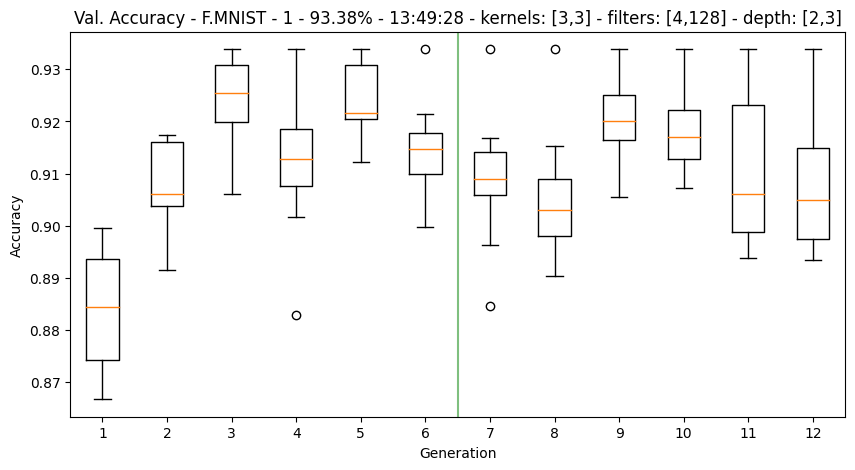

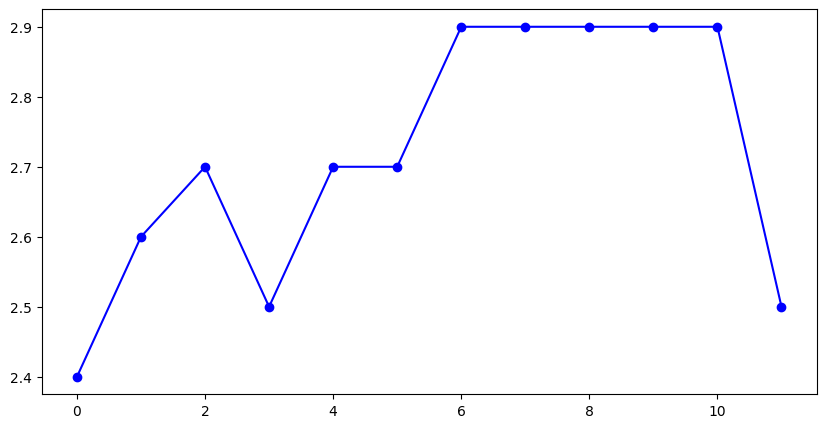

Best cromosome: [3, 16, 3, 128, 3, 128, 3]
Number of curves: 12
Test size: 10000


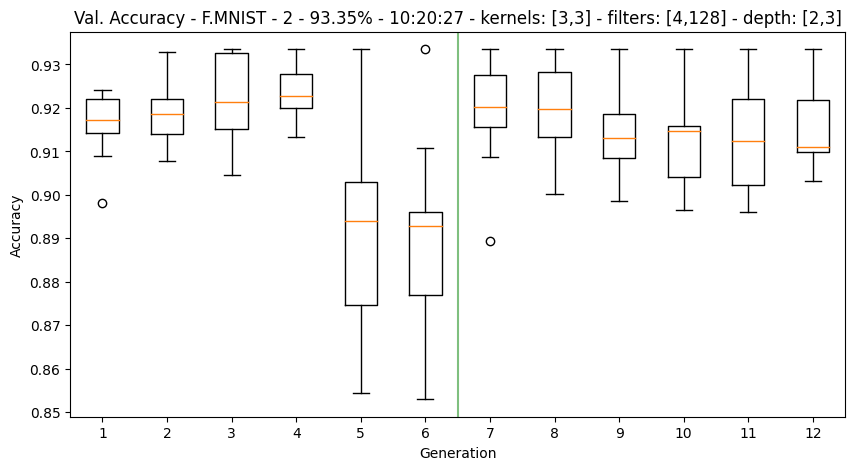

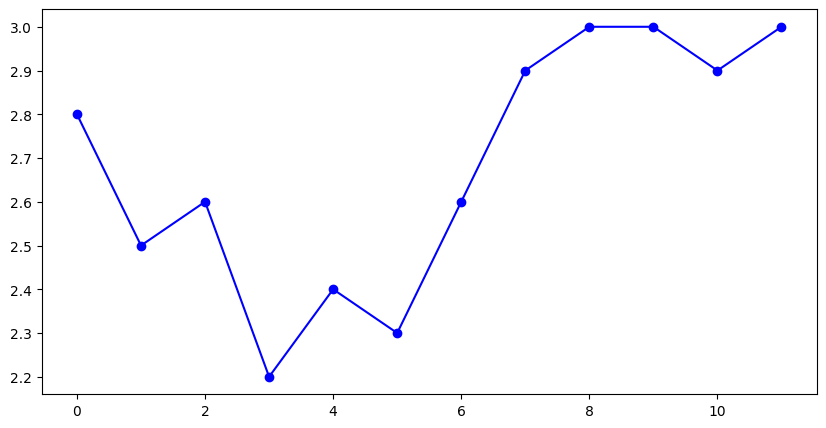

Best cromosome: [7, 32, 3, 64, 3, 128, 7, 16, 3, 64, 7, 64, 7, 64, 5]
Number of curves: 12
Test size: 10000


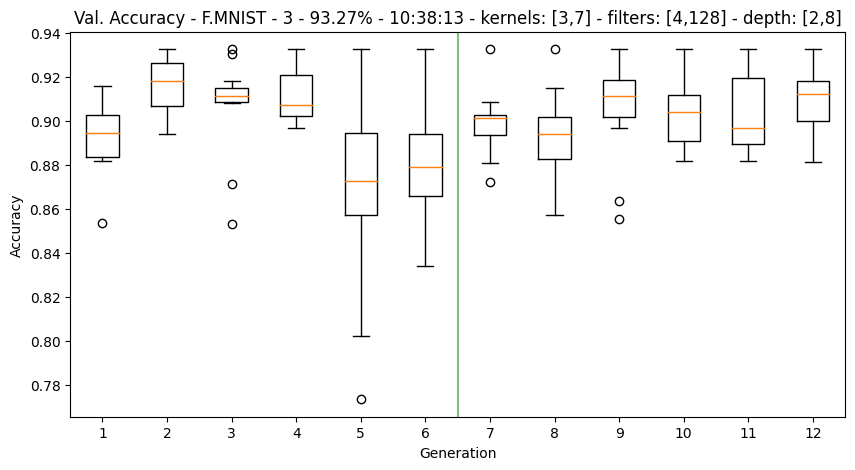

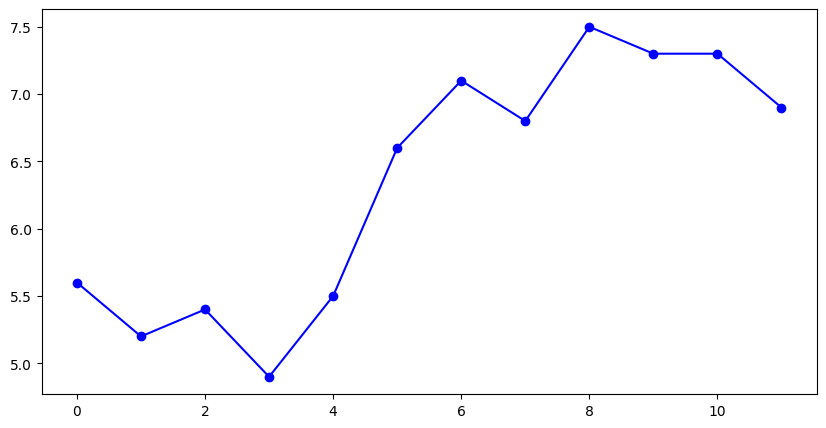

Best cromosome: [8, 128, 3, 64, 7, 64, 5, 64, 3, 8, 3, 4, 7, 8, 3, 16, 3]
Number of curves: 12
Test size: 10000


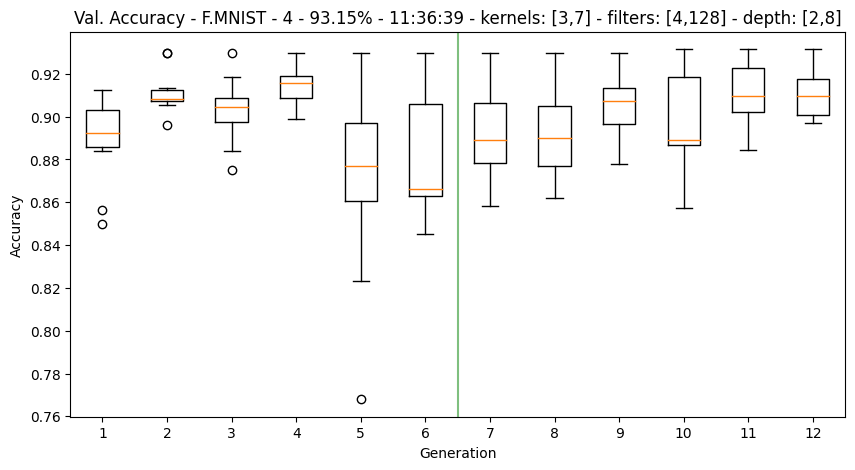

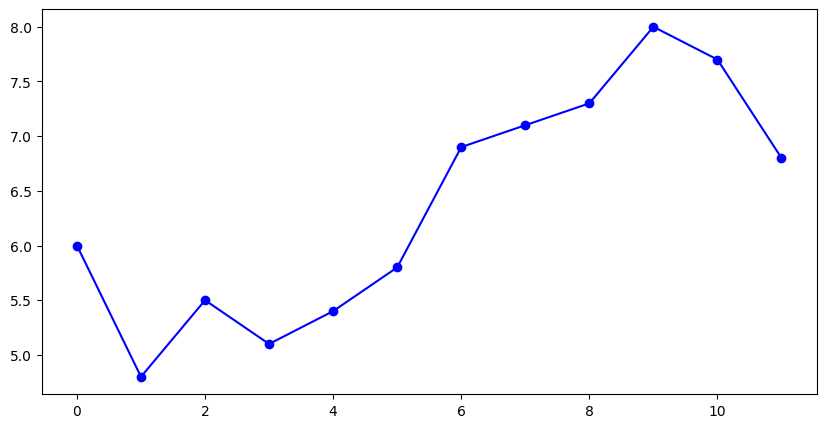

Best cromosome: [8, 32, 3, 16, 7, 8, 3, 32, 5, 8, 5, 32, 7, 8, 5, 128, 3]
Number of curves: 12
Test size: 10000


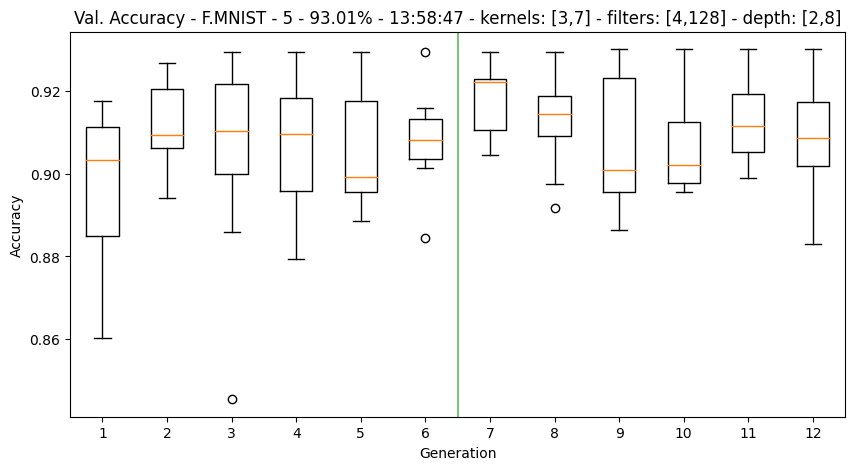

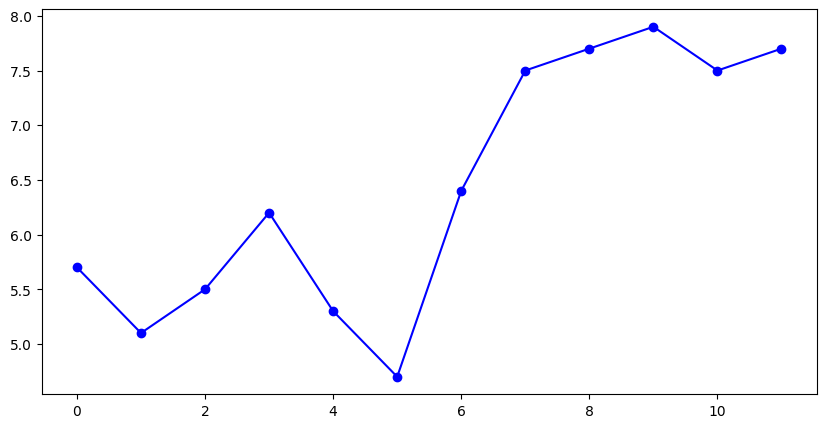

Best cromosome: [8, 128, 3, 16, 5, 64, 5, 64, 7, 16, 3, 128, 3, 8, 3, 64, 3]
Number of curves: 12
Test size: 10000


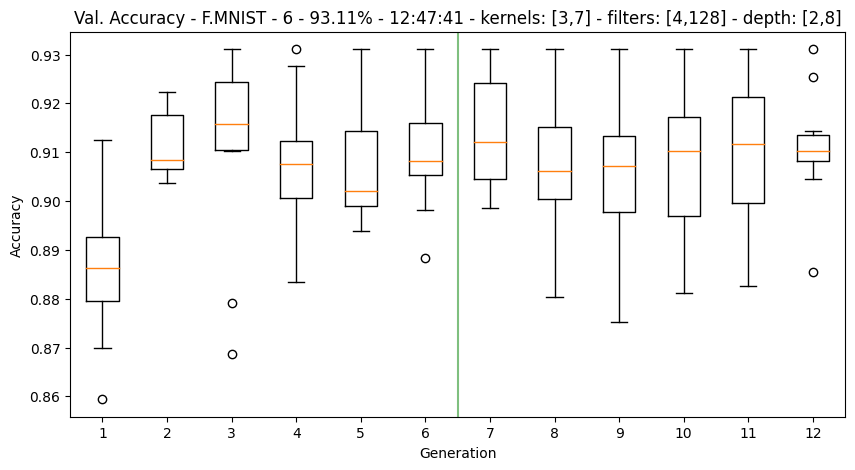

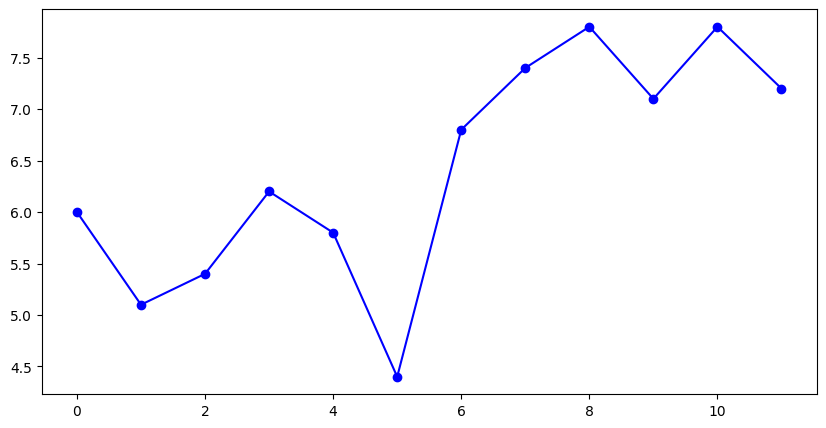

In [179]:
# Incializar boxplot_data
boxplot_data = np.array([])
time_data = np.array([])
acc_test_data = np.array([])
for i in range(6):
    params = np.load(f"models/mnist/model_params_{i}.npy", allow_pickle=True).item()
    model = torch.load(f"models/mnist/model_{i}.pt")
    print(f"Best cromosome: {params['best_cromosome']}")
    print(f"Number of curves: {len(params['val_accuracy_list'])}")
    time_data = np.append(time_data, params['time'])
    # Calcular accuracy en todo el conjunto de test
    test_data = get_data_MNIST(train_size=1)[2] 
    print(f"Test size: {len(test_data)}")
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)
    acc_test = 0
    for images, labels in test_loader:
        images = images.to(params['device'])
        labels = labels.to(params['device'])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        acc_test += (predicted == labels).sum().item()
    acc_test /= len(test_data)
    acc_test_data = np.append(acc_test_data, acc_test)
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    
    # Curva con el mejor accuracy
    max_acc = np.max(params['val_accuracy_list'], axis=1)
    for j in range(1, len(max_acc)): # Graficar elite
        if max_acc[j] < max_acc[j-1]: max_acc[j] = max_acc[j-1]
    
    # Graficar curva maxima de accuracy
    acc_list = np.array(params['val_accuracy_list']).T
    acc_list = np.vstack((acc_list, max_acc))
    
    # Graficar boxplot
    ax.boxplot(acc_list, showfliers=True)
    # tiempo en hh:mm:ss
    title = f"Val. Accuracy - F.MNIST - {i+1}"
    title += f" - {100*np.max(params['val_accuracy_list']):.2f}%"
    title += f" - {time.strftime('%H:%M:%S', time.gmtime(params['time']))}"
    title += f" - kernels: [{min(params['kernel_sizes'])},{max(params['kernel_sizes'])}]"
    title += f" - filters: [{min(params['filters'])},{max(params['filters'])}]"
    title += f" - depth: [{min(params['depths'])},{max(params['depths'])}]"
    ax.set_title(title)
    # Linea horizontal verde en la mitad del grafico
    ax.axvline(x=len(params['val_accuracy_list'])/2+0.5, color='green', alpha=0.5)
    ax.set_xlabel("Generation")
    ax.set_ylabel("Accuracy")
    # Ticks para el eje x
    ax.set_xticks(np.arange(1, 13))
    plt.show()
    # Graficar profundidad promedio por generacion, cantidad de kernels y cantidad de filtros
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    mean_depth = []
    for generation in params['generations_list']:
        mean_depth.append(np.mean([cromosome[0] for cromosome in generation]))
    ax.plot(mean_depth, color='blue', alpha=1, marker='o')
    plt.show()
    # Boxplot
    if i == 0:
        boxplot_data = max_acc
    boxplot_data = np.vstack((boxplot_data, max_acc))
    
    
     

In [183]:
# Tiempo promedio
print(f"Tiempo promedio hh:mm:ss: {time.strftime('%H:%M:%S', time.gmtime(np.mean(time_data)))}+-{time.strftime('%H:%M:%S', time.gmtime(np.std(time_data)))} , Cantidad de experimentos = {len(time_data)}")
# Accuracy promedio
print(f"Accuracy promedio de test: {np.mean(acc_test_data)}+-{np.std(acc_test_data)}")

Tiempo promedio hh:mm:ss: 12:11:53+-01:26:16 , Cantidad de experimentos = 6
Accuracy promedio de test: 0.9287333333333333+-0.00508090105744598


Text(0.5, 0, 'Generación')

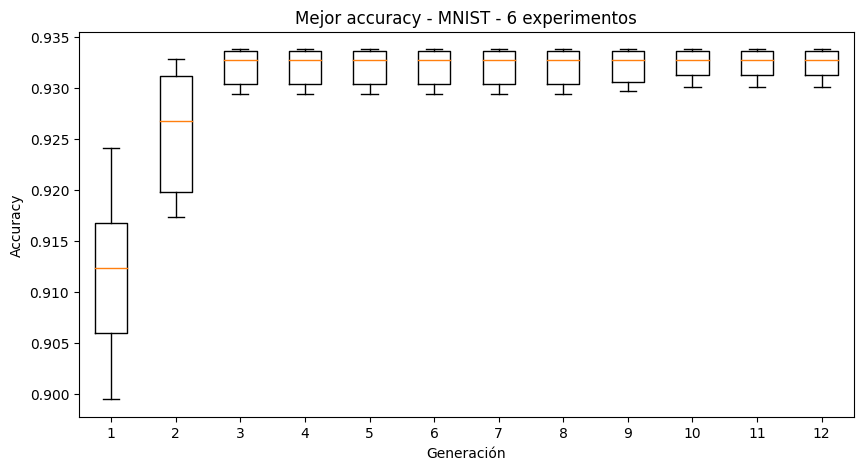

In [171]:
# Graficar boxplot
fig, ax = plt.subplots(1,1, figsize=(10,5))
# Boxplot con los ultimos 3 filas
ax.boxplot(boxplot_data[:,:])
ax.set_ylabel("Accuracy")
# Titulo al boxplot de los mejores por experimento
ax.set_title("Mejor accuracy - MNIST - 6 experimentos")
# eje x title
ax.set_xlabel("Generación")